# Dimensionality Reduction of the Higgs Dataset: A Scalable PCA Implementation with Spark MLlib

In [5]:
!pip install pyspark

In [7]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("ScalablePCA") \
    .master("local[*]") \
    .getOrCreate()

# Print the session object to confirm it's running
print(spark)

In [8]:
# 1. Download the dataset from the UCI repository
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

# 2. Decompress the .gz file
!gzip -d HIGGS.csv.gz

# 3. Load the CSV file into a Spark DataFrame
# inferSchema=True tells Spark to automatically figure out the column data types (e.g., double, integer)
# header=False because this specific file does not contain a header row
df = spark.read.csv("HIGGS.csv", header=False, inferSchema=True)

# Let's give our columns meaningful names for easier reference
# The first column is the label (0 for background, 1 for Higgs signal)
# The next 28 are the features
feature_cols = ['feature_' + str(i) for i in range(1, 29)]
df = df.toDF('label', *feature_cols)

# Verify the schema and see the first 5 rows
print("DataFrame Schema:")
df.printSchema()

print("\nFirst 5 rows of the DataFrame:")
df.show(5)

--2025-09-01 18:47:12--  http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [                <=> ]   2.62G  88.5MB/s    in 38s     

2025-09-01 18:47:51 (70.1 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]

DataFrame Schema:
root
 |-- label: double (nullable = true)
 |-- feature_1: double (nullable = true)
 |-- feature_2: double (nullable = true)
 |-- feature_3: double (nullable = true)
 |-- feature_4: double (nullable = true)
 |-- feature_5: double (nullable = true)
 |-- feature_6: double (nullable = true)
 |-- feature_7: double (nullable = true)
 |-- feature_8: double (nullable = true)
 |-- feature_9: double (nullable = true)
 |-- feature_10: double (nullable = true)
 |-- feature_11: double (

In [12]:
from pyspark.sql.functions import col

# 1. Check for Null Values in each column
print("Null value counts per column:")
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    print(f"{column}: {null_count}")

# 2. Check for Duplicate Rows
total_rows = df.count()
distinct_rows = df.distinct().count()
duplicate_row_count = total_rows - distinct_rows

print(f"\\nTotal rows: {total_rows}")
print(f"Distinct rows: {distinct_rows}")
print(f"Number of duplicate rows found: {duplicate_row_count}")

Null value counts per column:
label: 0
feature_1: 0
feature_2: 0
feature_3: 0
feature_4: 0
feature_5: 0
feature_6: 0
feature_7: 0
feature_8: 0
feature_9: 0
feature_10: 0
feature_11: 0
feature_12: 0
feature_13: 0
feature_14: 0
feature_15: 0
feature_16: 0
feature_17: 0
feature_18: 0
feature_19: 0
feature_20: 0
feature_21: 0
feature_22: 0
feature_23: 0
feature_24: 0
feature_25: 0
feature_26: 0
feature_27: 0
feature_28: 0
\nTotal rows: 11000000
Distinct rows: 10721302
Number of duplicate rows found: 278698


In [13]:
# Create a new DataFrame with duplicate rows removed
df_cleaned = df.dropDuplicates()

# Verify the new count
new_count = df_cleaned.count()

print(f"Original row count: {total_rows}")
print(f"New row count after dropping duplicates: {new_count}")

# We will use 'df_cleaned' for all subsequent steps

Original row count: 11000000
New row count after dropping duplicates: 10721302


In [14]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

# --- Step 4: Feature Engineering on the Cleaned Data ---

# 1. Assemble feature columns into a single vector
# Note: We are now using df_cleaned as the input
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")
df_assembled = assembler.transform(df_cleaned)

# 2. Scale the features
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

In [15]:
# Let's verify the result by showing the new scaled_features column
print("DataFrame with the new scaled feature vector:")
df_scaled.select("scaled_features").show(5, truncate=False)

DataFrame with the new scaled feature vector:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                                                                                                                                                                                           

In [16]:
# --- Step 5: PCA on the Scaled, Cleaned Data ---

# Set k, the number of principal components
k_components = 5

# Create and fit the PCA model
pca = PCA(k=k_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)

# Transform the data to get the principal components
df_pca = pca_model.transform(df_scaled)

# Show the final results
print(f"DataFrame transformed into {k_components} Principal Components:")
df_pca.select("pca_features").show(5, truncate=False)

DataFrame transformed into 5 Principal Components:
+----------------------------------------------------------------------------------------------------+
|pca_features                                                                                        |
+----------------------------------------------------------------------------------------------------+
|[0.5470208925243775,-0.4611135605267379,1.4185229952883252,-0.7063147411793095,1.5763948873579734]  |
|[1.3247824249202396,-0.5692329800287577,0.2316370664079374,-0.20750955182994474,0.2973508574982661] |
|[0.09729963259230842,-0.976369405315203,-0.13362781940800084,0.562630886452573,0.5403022098976066]  |
|[1.2433791997750945,-1.422792885223716,-1.3354738029043234,0.5127151848718146,0.9207464333364523]   |
|[2.4376396287326427,1.2588950126595964,-1.4270310078472812,-0.11900701480601261,-1.0596855120945483]|
+----------------------------------------------------------------------------------------------------+
only showing top 5 row

In [18]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

# 1. Create a UDF to convert the Vector column to a standard array column
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Apply the UDF to create a new temporary column with the features as an array
df_pca_array = df_pca.withColumn("pca_array", vector_to_array_udf(col("pca_features")))

# 2. Now, we can easily extract elements from the new 'pca_array' column
df_pca_split = df_pca_array
for i in range(k_components):
    df_pca_split = df_pca_split.withColumn(f"PC{i+1}", col("pca_array")[i])

# Show the result with the new, separate PC columns.
# We can also drop the temporary array column for a cleaner final view.
print("DataFrame with Principal Components as separate columns:")
df_pca_split.select("PC1", "PC2", "PC3", "PC4", "PC5").show(5)

DataFrame with Principal Components as separate columns:
+-------------------+-------------------+--------------------+--------------------+-------------------+
|                PC1|                PC2|                 PC3|                 PC4|                PC5|
+-------------------+-------------------+--------------------+--------------------+-------------------+
| 0.5470208925243775|-0.4611135605267379|  1.4185229952883252| -0.7063147411793095| 1.5763948873579734|
| 1.3247824249202396|-0.5692329800287577|  0.2316370664079374|-0.20750955182994474| 0.2973508574982661|
|0.09729963259230842| -0.976369405315203|-0.13362781940800084|   0.562630886452573| 0.5403022098976066|
| 1.2433791997750945| -1.422792885223716| -1.3354738029043234|  0.5127151848718146| 0.9207464333364523|
| 2.4376396287326427| 1.2588950126595964| -1.4270310078472812|-0.11900701480601261|-1.0596855120945483|
+-------------------+-------------------+--------------------+--------------------+-------------------+
only sh

--- PCA Evaluation ---
Principal Component 1: explains 0.1486 (14.86%) of the variance.
Principal Component 2: explains 0.0667 (6.67%) of the variance.
Principal Component 3: explains 0.0643 (6.43%) of the variance.
Principal Component 4: explains 0.0504 (5.04%) of the variance.
Principal Component 5: explains 0.0479 (4.79%) of the variance.
\nTotal Variance Explained by 5 components: 0.3778 (37.78%)


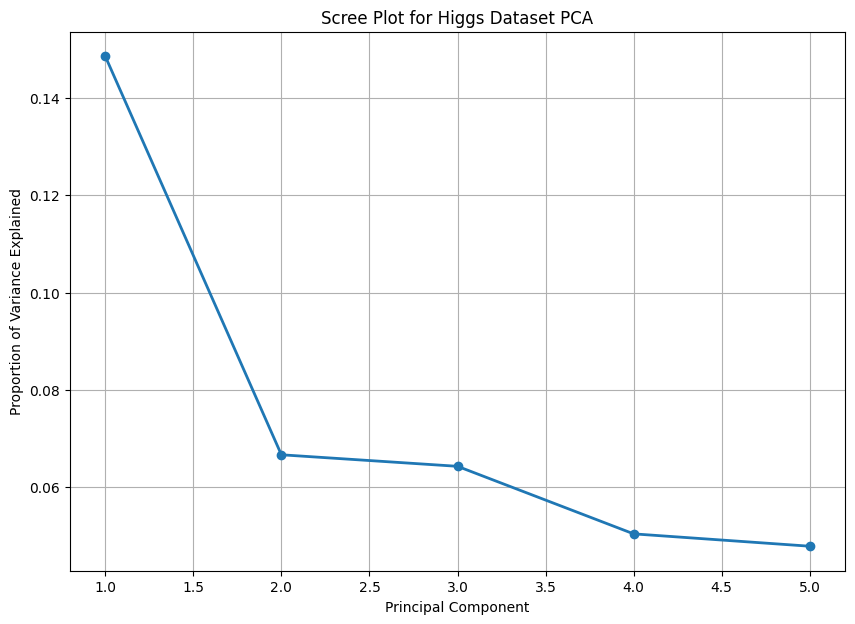

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract the explained variance from the fitted PCA model
explained_variance = pca_model.explainedVariance

print("--- PCA Evaluation ---")
# 2. Print the variance explained by each component
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: explains {variance:.4f} ({variance:.2%}) of the variance.")

# 3. Print the cumulative variance
print(f"\\nTotal Variance Explained by {k_components} components: {sum(explained_variance):.4f} ({sum(explained_variance):.2%})")

# 4. Create a Scree Plot for visualization
pc_numbers = np.arange(len(explained_variance)) + 1
plt.figure(figsize=(10, 7))
plt.plot(pc_numbers, explained_variance, 'o-', linewidth=2)
plt.title('Scree Plot for Higgs Dataset PCA')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid(True)
plt.show()

Taking a 0.1% sample of the data for visualization...
Creating Scatter Plot of PC1 vs PC2...


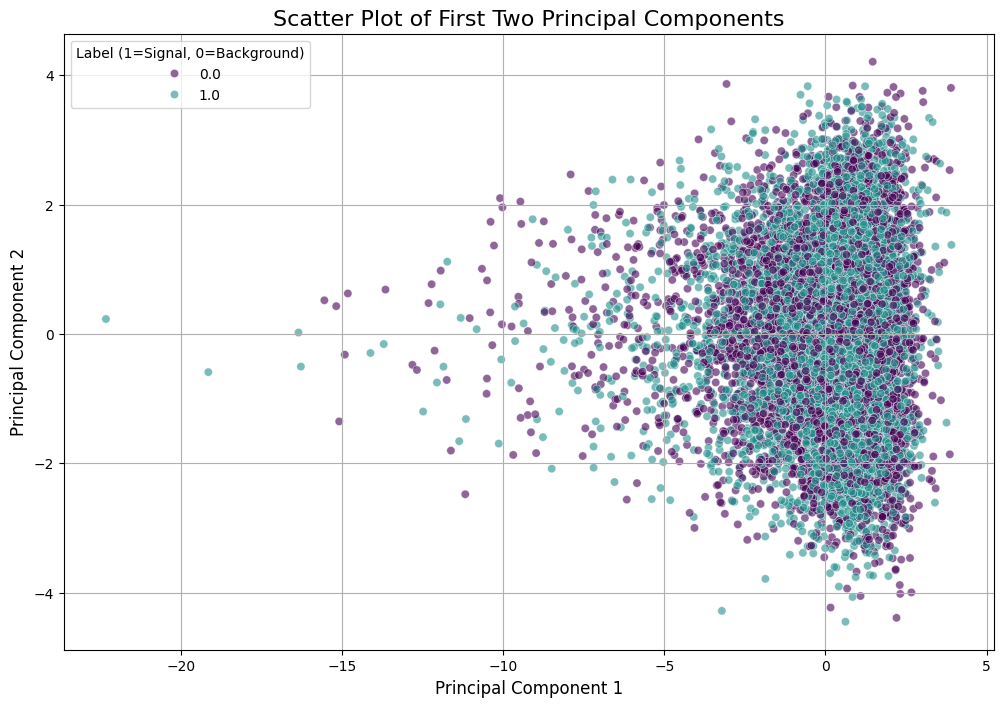

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Visualization 1: Principal Component Scatter Plot ---

# Take a small random sample (0.1% of the data) for plotting
print("Taking a 0.1% sample of the data for visualization...")
sample_df_pd = df_pca_split.sample(False, 0.001, seed=42).toPandas()

print("Creating Scatter Plot of PC1 vs PC2...")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='label',
    data=sample_df_pd,
    alpha=0.6,
    palette=['#440154', '#21908d'] # Using a colorblind-friendly palette
)
plt.title('Scatter Plot of First Two Principal Components', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Label (1=Signal, 0=Background)')
plt.grid(True)
plt.show()

\nCreating Cumulative Explained Variance Plot...


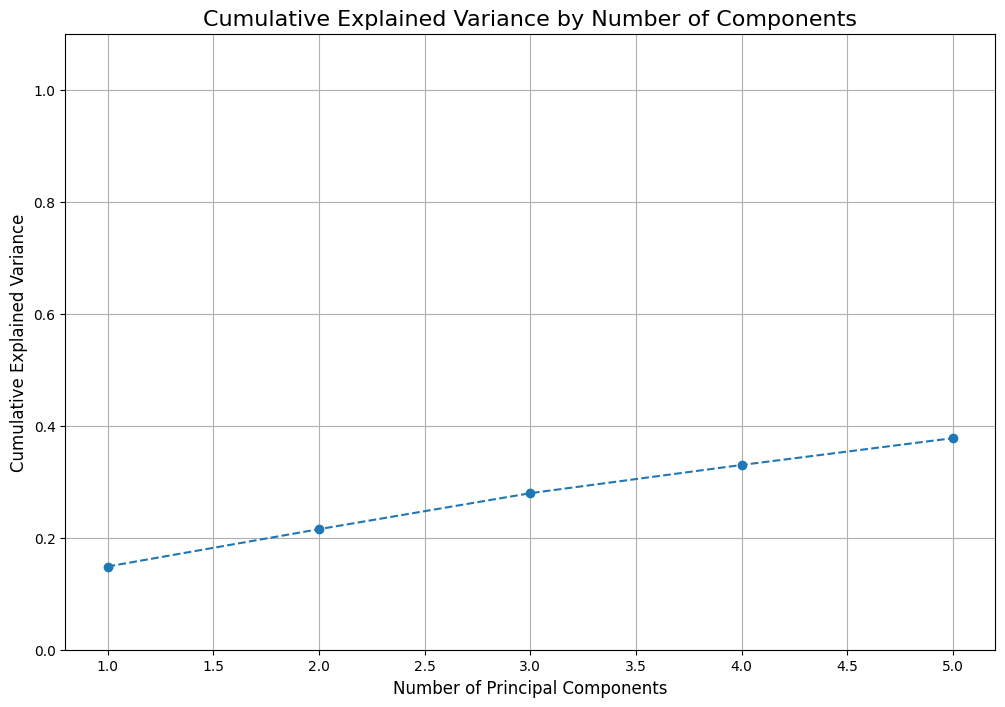

In [21]:
# --- Visualization 2: Cumulative Explained Variance Plot ---

# We already have the explained_variance from the previous step
# explained_variance = pca_model.explainedVariance
cumulative_variance = np.cumsum(explained_variance)

print("\\nCreating Cumulative Explained Variance Plot...")
plt.figure(figsize=(12, 8))
plt.plot(range(1, k_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Components', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
# Add a horizontal line for a common threshold, e.g., 90%
# plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()


Starting Scalability Analysis. This will take a while...
\n--- Processing 20% of the data ---
Subset size: 2145344 rows
Time taken for 2145344 rows: 47.17 seconds
\n--- Processing 40% of the data ---
Subset size: 4287941 rows
Time taken for 4287941 rows: 92.34 seconds
\n--- Processing 60% of the data ---
Subset size: 6431654 rows
Time taken for 6431654 rows: 137.58 seconds
\n--- Processing 80% of the data ---
Subset size: 8575545 rows
Time taken for 8575545 rows: 153.72 seconds
\n--- Processing 100% of the data ---
Subset size: 10721302 rows
Time taken for 10721302 rows: 189.59 seconds
\nCreating Scalability Plot...


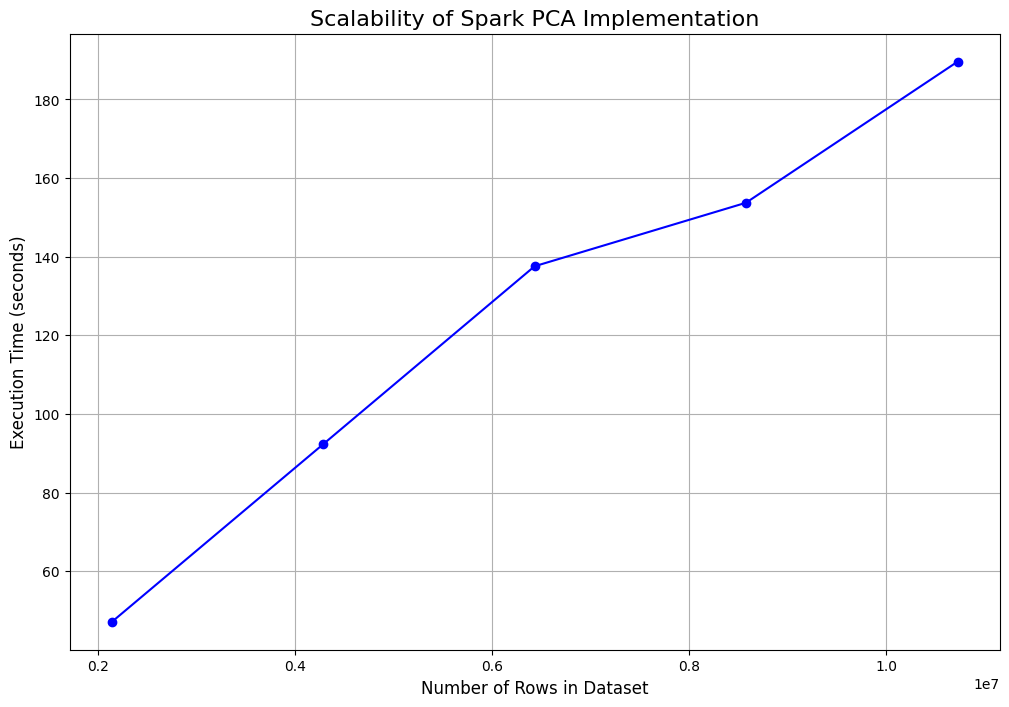

In [22]:
import time
import matplotlib.pyplot as plt
import pandas as pd

# We will test on these fractions of the data
data_fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
execution_times = []
data_sizes = []

print("Starting Scalability Analysis. This will take a while...")

# Use the cleaned, non-assembled dataframe as our base
base_df = df_cleaned

for fraction in data_fractions:
    print(f"\\n--- Processing {fraction*100:.0f}% of the data ---")

    # Take a sample of the data. Use 'withReplacement=False'
    if fraction < 1.0:
        subset_df = base_df.sample(False, fraction, seed=42)
    else:
        subset_df = base_df

    # Cache the subset to keep it in memory for more accurate timing of the PCA steps
    subset_df.cache()

    # Get the actual number of rows in the subset (this action forces the sample to be taken)
    num_rows = subset_df.count()
    data_sizes.append(num_rows)
    print(f"Subset size: {num_rows} rows")

    # Start the timer
    start_time = time.time()

    # --- Re-run the core pipeline on the subset ---
    # 1. Assemble features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")
    df_assembled = assembler.transform(subset_df)

    # 2. Scale features
    scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features", withStd=True, withMean=True)
    scaler_model = scaler.fit(df_assembled)
    df_scaled = scaler_model.transform(df_assembled)

    # 3. Apply PCA
    pca = PCA(k=k_components, inputCol="scaled_features", outputCol="pca_features")
    pca_model = pca.fit(df_scaled)
    # We use .transform() and an action (.count()) to ensure the entire pipeline is executed
    df_pca = pca_model.transform(df_scaled)
    df_pca.count()

    # Stop the timer
    end_time = time.time()

    # Calculate and store the duration
    duration = end_time - start_time
    execution_times.append(duration)
    print(f"Time taken for {num_rows} rows: {duration:.2f} seconds")

    # Unpersist the cached subset to free up memory
    subset_df.unpersist()

# --- Create the Scalability Plot ---
print("\\nCreating Scalability Plot...")
plt.figure(figsize=(12, 8))
plt.plot(data_sizes, execution_times, marker='o', linestyle='-', color='b')
plt.title('Scalability of Spark PCA Implementation', fontsize=16)
plt.xlabel('Number of Rows in Dataset', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.grid(True)
plt.show()

In [23]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# The df_pca DataFrame already contains our 'label' and 'pca_features' columns,
# which is the perfect format for training.

# 1. Split the data into training (80%) and test (20%) sets
(train_data, test_data) = df_pca.randomSplit([0.8, 0.2], seed=42)

print(f"Training set count: {train_data.count()}")
print(f"Test set count: {test_data.count()}")

# 2. Define and train the Logistic Regression model
# We tell the model that our features are in the 'pca_features' column
# and the target is in the 'label' column.
lr = LogisticRegression(featuresCol='pca_features', labelCol='label')
lr_model = lr.fit(train_data)

# 3. Make predictions on the test data
predictions = lr_model.transform(test_data)

# 4. Evaluate the model's performance
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print("\\n--- Model Evaluation ---")
print(f"Model: Logistic Regression")
print(f"Features: 5 Principal Components")
print(f"Accuracy on Test Data: {accuracy:.4f} ({accuracy:.2%})")
print(f"F1 Score on Test Data: {f1_score:.4f}")

Training set count: 8577439
Test set count: 2143863
\n--- Model Evaluation ---
Model: Logistic Regression
Features: 5 Principal Components
Accuracy on Test Data: 0.5638 (56.38%)
F1 Score on Test Data: 0.5176
